# Text Semtiment Analysis via Deep Reinforcement Learning

In [1]:
import os
import jieba
import pickle
import pydot
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import Word2Vec
from IPython.display import Image
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

C:\Users\TomJx\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\TomJx\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\TomJx\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\TomJx\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
tf.__version__

'1.12.0'

This dataset is released in NLPCC2014
http://tcci.ccf.org.cn/conference/2014/index.html

In [3]:
with open(r'./weibo_senti_100k/weibo_senti_100k.csv', 'r', encoding='utf-8') as handle:
    df = pd.read_csv(handle)
print('comments: %d' % df.shape[0])
print('positive samples: %d' % df[df.label==1].shape[0])
print('negative samples: %d' % df[df.label==0].shape[0])

comments: 119988
positive samples: 59993
negative samples: 59995


In [4]:
comments = df['review'].tolist()
sentiments = df['label'].tolist()
num_actions = len(set(sentiments))
x_train, x_test, y_train, y_test = train_test_split(comments, sentiments, test_size=0.2, random_state=42)
print('Actions: {}'.format(num_actions))
print('Train set: {}, Test set: {}'.format(len(y_train), len(y_test)))

Actions: 2
Train set: 95990, Test set: 23998


#### Pretrain word embeddings via Word2Vec

In [5]:
def seg_word(doc):
    seg_list = jieba.cut(doc, cut_all=False)
    return list(seg_list)

def get_char(arr):
    res = []
    for c in arr:
        res.append(c)
    return list(res)

In [6]:
# Segment
comments_seg = [get_char(x) for x in comments]
train_seg = [get_char(x) for x in x_train]
test_seg = [get_char(x) for x in x_test]

In [7]:
if not os.path.exists(r'./token/chars.vector'):
    word2vec_model = Word2Vec(comments_seg, size=100, window=10, min_count=1, workers=4, iter=15)
    word2vec_model.wv.save_word2vec_format(r'./token/chars.vector', binary=True)

In [8]:
# Take one-hot encoding for sentiment label.
actions = np.ones((1, num_actions))

tr_one_hot = tf.keras.utils.to_categorical(y_train, num_actions)
ts_one_hot = tf.keras.utils.to_categorical(y_test, num_actions)

#### Model definition

In [9]:
class Network(tf.keras.Model):
    '''
    Definition of Bi-directional LSTM based model via functional API, using tf.keras.applications.
    '''

    def __init__(self, action_nums, embeddings_matrix, encode_size=64, maxlen=100, dp_rate=0.2):
        super(Network, self).__init__()
        self.actions = action_nums # actions
        
        # Model struction
        self.embds = tf.keras.layers.Embedding(embeddings_matrix.shape[0],
                                         embeddings_matrix.shape[1],
                                         weights=[embeddings_matrix],
                                         input_length=maxlen,
                                         trainable=True)
        self.spatial_dp = tf.keras.layers.SpatialDropout1D(dp_rate)
        self.lstm_1 = tf.keras.layers.CuDNNLSTM(encode_size, 
                                                return_sequences=True)
        self.bi_lstm_1 = tf.keras.layers.Bidirectional(self.lstm_1)
        self.max_pool = tf.keras.layers.GlobalMaxPool1D()
        
        self.logits = tf.keras.layers.Dense(self.actions, name='q_outputs')
        self.multipy = tf.keras.layers.Multiply()
        self.sum = tf.keras.layers.Lambda(lambda x:tf.reduce_sum(x, axis=1,keepdims=True),name='q_value')
    def call(self, inputs, training=None):
        # Construction
        x = inputs[0]
        act = inputs[1]
        
        x = self.embds(x)
        x = self.spatial_dp(x)
        x = self.bi_lstm_1(x)
        x = self.max_pool(x)
        logits = self.logits(x)
        #q_val = tf.keras.layers.multiply([act, logits])
        q_val = self.multipy([act, logits])
        q_val = self.sum(q_val)

        return q_val

#### Environment

In [10]:
class Environment(object):
    def __init__(self, x, y):
        self.train_X = x
        self.train_Y = y
        self.current_index = self.sample_index()
        self.action_space = len(set(y)) - 1
        
    def reset(self):
        '''
        Sampling randomly if start or no reward.
        '''
        obs, _ = self.step(-1)
        return obs

    def step(self, action):
        '''
        Return the current reward and a sample as the next state.
        '''
        if action == -1: # At the begining or no reward at current state.
            current_index = self.current_index
            self.current_index = self.sample_index()
            return (self.train_X[current_index], 0)
        r = self.reward(action)
        self.current_index = self.sample_index()
        return self.train_X[self.current_index], r
    
    def reward(self, action):
        '''
        Return reward 1 if the prediction is correct, otherwise return -1.
        '''
        c = self.train_Y[self.current_index]
        return 1 if c==action else -1
        
    def sample_actions(self):
        return random.randint(0, self.action_space)
    
    def sample_index(self):
        return random.randint(0, len(self.train_Y)-1)

#### Word embedding

In [12]:
maxlen = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None)
tokenizer.fit_on_texts(comments_seg)
with open(r'./token/tokenizer_chars.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
w2_model = KeyedVectors.load_word2vec_format(r'./token/chars.vector', 
                                             binary=True, 
                                             encoding='utf8',
                                             unicode_errors='ignore')
embeddings_index = {}
embeddings_matrix = np.zeros((len(word_index) + 1, w2_model.vector_size))
word2idx = {"_PAD": 0}
vocab_list = [(k, w2_model.wv[k]) for k, v in w2_model.wv.vocab.items()]

for word, i in word_index.items():
    if word in w2_model:
        embedding_vector = w2_model[word]
    else:
        embedding_vector = None
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector
list_tokenized_train = tokenizer.texts_to_sequences(train_seg)

# Train data max length is set to 100
input_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                                            maxlen=maxlen)

list_tokenized_validation = tokenizer.texts_to_sequences(test_seg)

# Test data max length is set to 100
input_validation = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validation, 
                                          maxlen=maxlen)

C:\Users\TomJx\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [13]:
ENV = Environment(input_train, y_train)
ALPHA = 0.5
BATCH_SIZE = 32
EPOCHS = 3000
EPSILON_TOTAL = 2020
PRE_TRAIN_NUMS = 16
QUE = deque(maxlen=32)
TRAIN_STEPS = 64
TRANSFER_STEP = 16

In [ ]:
def train(samples):
    if len(samples) < BATCH_SIZE:
        return 

    samples = np.array(samples)
    states, actions, old_q, rewards, next_states = zip(*samples)
    states, actions, old_q, rewards = np.array(states),np.array(actions).reshape(-1,1),\
                                    np.array(old_q).reshape(-1,1),np.array(rewards).reshape(-1,1)
    actions_one_hot = tf.keras.utils.to_categorical(actions, num_actions)

    q_estimate = (1-ALPHA) * old_q +  ALPHA * rewards.reshape(-1,1)
    history = critic_model.fit([states,actions_one_hot],q_estimate, batch_size=BATCH_SIZE, epochs=1,verbose=0, shuffle=True)
    return np.mean(history.history['loss'])

In [17]:
def get_q_values(model, state):
    inputs = [state.reshape(1,*state.shape),actions]
    qvalues = model.predict(inputs)
    return qvalues[0]


def predict(model, inputs):
    '''
    Return the position of the max q_outputs as the prediction.
    '''
    q_outputs = model.predict(inputs)
    return np.argmax(q_outputs, axis=1)


def epsilon_calc(step, ep_min=0.01,ep_max=1, esp_total = 1000):
    return max(ep_min, ep_max - (ep_max - ep_min)*step/esp_total )


def epsilon_greedy(env, state, step, ep_min=0.01, ep_total=1000):
    epsilon = epsilon_calc(step, ep_min, 1, ep_total)
    if np.random.rand()<epsilon:
        return env.sample_actions(), 0
    qvalues = get_q_values(actor_q_model, state)
    return np.argmax(qvalues), np.max(qvalues)


def pre_enque(pre_go=30):
    state = ENV.reset()
    for i in range(pre_go):
        rdn_action = ENV.sample_actions()
        next_state, reward = ENV.step(rdn_action)
        QUE.append([state, rdn_action, 0, reward, next_state])
        state = next_state

In [18]:
# Network input layers
inputs = tf.keras.Input(shape=(maxlen,), 
                        name='embds_input')
act_input = tf.keras.Input((num_actions,),
                      name='actions_input')

In [19]:
# Actor-Critic

# Train
critic_model = Network(num_actions, embeddings_matrix)
_ = critic_model(inputs=[inputs, act_input])
critic_model.compile(loss='mse',optimizer='adam')

# Decision
actor_q_model = tf.keras.Model(inputs=critic_model.input, outputs=critic_model.get_layer('q_outputs').output)

In [20]:
QUE.clear()
total_rewards = 0
reward_rec = []
pre_enque(PRE_TRAIN_NUMS)

In [21]:
# Training

process_bar = tqdm(range(1, EPOCHS + 1))
state = ENV.reset()
for epoch in process_bar:
    total_rewards = 0
    epo_start = time.time()
    for step in range(TRAIN_STEPS):
        # Epsilon greedy for each state
        action, q = epsilon_greedy(ENV, state, epoch, ep_min=0.01,
                                   ep_total=EPSILON_TOTAL)
        eps = epsilon_calc(epoch, esp_total=EPSILON_TOTAL)
        # Obtain the current reward and next state.
        next_state, reward = ENV.step(action)
        # Add the above contain into a queue
        QUE.append([state, action, q, reward, next_state])
        # Train
        loss = train(QUE)
        total_rewards += reward
        state = next_state
        if step % TRANSFER_STEP == 0:
            actor_q_model = tf.keras.Model(inputs=critic_model.input,
                                           outputs=critic_model.get_layer('q_outputs').output)
    reward_rec.append(total_rewards)
    process_bar.set_description('Reward:{} Loss:{:.4f} Epsilon:{:.3f} Time:{} '.format(total_rewards, loss, eps,int(time.time() - epo_start)))

  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]C:\Users\TomJx\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Reward:56 Loss:0.0393 Epsilon:0.010 Time:5 : 100%|███████████████████████████████| 3000/3000 [2:19:20<00:00,  2.79s/it]


In [22]:
# Save model
critic_model.save_weights(r'./saved_model/DRL/crtic_3000.HDF5')


Consider using a TensorFlow optimizer from `tf.train`.


Text(0, 0.5, 'Rewards')

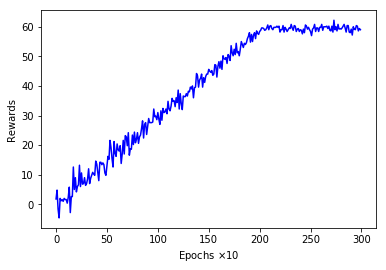

In [51]:
cruve = np.mean([reward_rec[i:i+10] for i in range(0,len(reward_rec),10)],axis=1)
plt.plot(range(len(cruve)), cruve, c='b')
plt.xlabel(r'Epochs $ \times 10$')
plt.ylabel('Rewards')

In [24]:
# Load model
critic_model = Network(num_actions, embeddings_matrix)
_ = model_loaded(inputs=[inputs, act_input])
critic_model.load_weights(r'./saved_model/DRL/crtic_3000.HDF5')

In [25]:
actor_q_model = tf.keras.Model(inputs=critic_model.input, outputs=critic_model.get_layer('q_outputs').output)

In [40]:
def metrics(y_test, pred):
    '''
    Evaluate the trained model.
    '''
    acc = accuracy_score(y_test,pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    print('acc: {}, macro pre: {}, macro rec: {}, macro f1: {}'.format(acc, precision, recall, f1))
    confuse_mat = confusion_matrix(y_test, pred)
    print('confuse matrix: \n {}'.format(confuse_mat))

In [41]:
ones = np.ones(shape=(len(test_seg),num_actions))
pred = predict(actor_q_model, (input_validation, ones))
print('On validate data: ')
metrics(y_test, pred)

On validate data: 
acc: 0.9654554546212184, macro pre: 0.9657751791396896, macro rec: 0.9656634237518212, macro f1: 0.9654550006026692
confuse matrix: 
 [[11628   216]
 [  613 11541]]


In [42]:
ones_tr = np.ones(shape=(len(train_seg), num_actions))
pred_tr = predict(actor_q_model, (input_train, ones_tr))
print('On train data: ')
metrics(y_train, pred_tr)

On train data: 
acc: 0.9685904781748099, macro pre: 0.9690694079981084, macro rec: 0.9685406068498181, macro f1: 0.9685797344572546
confuse matrix: 
 [[47375   776]
 [ 2239 45600]]


#### Trained by LSTM

In [33]:
class LSTM(tf.keras.Model):
    '''
    Definition of Bi-directional LSTM based model via functional API, using tf.keras.applications.
    '''

    def __init__(self, class_nums, embeddings_matrix, encode_size=64, maxlen=100, conv_filters=64, dp_rate=0.2):
        super(LSTM, self).__init__()
        self.classes = class_nums # actions
        
        # Model struction
        self.embds = tf.keras.layers.Embedding(len(word_index) + 1,
                                         embeddings_matrix.shape[1],
                                         weights=[embeddings_matrix],
                                         input_length=maxlen,
                                         trainable=True)
        self.spatial_dp = tf.keras.layers.SpatialDropout1D(dp_rate)
        self.lstm_1 = tf.keras.layers.CuDNNLSTM(encode_size, 
                                                return_sequences=True)
        self.bi_lstm_1 = tf.keras.layers.Bidirectional(self.lstm_1)
        self.max_pool = tf.keras.layers.GlobalMaxPool1D()
        
        self.logits = tf.keras.layers.Dense(self.classes, name='logits', activation='softmax')

    def call(self, inputs, training=None):
        # Construction
        x = inputs     
        x = self.embds(x)
        x = self.spatial_dp(x)
        x = self.bi_lstm_1(x)
        x = self.max_pool(x)
        logits = self.logits(x)

        return logits

In [34]:
class_nums = 2
lstm = LSTM(class_nums, embeddings_matrix)
_ = lstm(inputs=inputs)
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
rmsprop = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
lstm.compile(loss='categorical_crossentropy',optimizer=adam)

In [35]:
lstm.fit(input_train, tr_one_hot, batch_size=32, epochs=20, verbose=1, shuffle=True)

C:\Users\TomJx\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
95990/95990 [==============================] - 46s 477us/step - loss: 0.1068
Epoch 2/20
95990/95990 [==============================] - 46s 484us/step - loss: 0.0845
Epoch 3/20
95990/95990 [==============================] - 47s 485us/step - loss: 0.0817
Epoch 4/20
95990/95990 [==============================] - 47s 486us/step - loss: 0.0792
Epoch 5/20
95990/95990 [==============================] - 46s 484us/step - loss: 0.0776
Epoch 6/20
95990/95990 [==============================] - 47s 485us/step - loss: 0.0758
Epoch 7/20
95990/95990 [==============================] - 46s 484us/step - loss: 0.0752
Epoch 8/20
95990/95990 [==============================] - 47s 485us/step - loss: 0.0737
Epoch 9/20
95990/95990 [==============================] - 47s 487us/step - loss: 0.0725
Epoch 10/20
95990/95990 [==============================] - 47s 484us/step - loss: 0.0720
Epoch 11/20
95990/95990 [==============================] - 47s 487us/step - loss: 0.0705
Epoch 12/20
95990/95990 [=====

In [44]:
# Save model
lstm.save_weights(r'./saved_model/LSTM/lstm_20.HDF5')


Consider using a TensorFlow optimizer from `tf.train`.


In [35]:
# Load model
lstm.load_weights(r'./saved_model/LSTM/lstm_20.HDF5')

In [43]:
pred = lstm.predict(input_validation)
pred = np.argmax(pred, axis=1)
print('On validate data: ')
metrics(y_test, pred)

On validate data: 
acc: 0.9653721143428619, macro pre: 0.9653743191963576, macro rec: 0.965451936554174, macro f1: 0.9653707433128357
confuse matrix: 
 [[11508   336]
 [  495 11659]]


In [44]:
pred_tr = lstm.predict(input_train)
pred_tr = np.argmax(pred_tr, axis=1)
print('On train data: ')
metrics(y_train, pred_tr)

On train data: 
acc: 0.9795186998645692, macro pre: 0.979638443442769, macro rec: 0.9794951867174951, macro f1: 0.9795164767969401
confuse matrix: 
 [[47512   639]
 [ 1327 46512]]


#### Trained by SVM

In [38]:
from sklearn import svm
tr_data = [np.mean(embeddings_matrix[microblog], axis=0) for microblog in input_train]
ts_data = [np.mean(embeddings_matrix[microblog], axis=0) for microblog in input_validation]

In [39]:
cls = svm.SVC()
cls.fit(tr_data, y_train)

C:\Users\TomJx\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [45]:
svm_pred = cls.predict(ts_data)

In [46]:
svm_pred_tr = cls.predict(tr_data)

In [47]:
svm_pred = svm_pred.tolist()
svm_pred_tr = svm_pred_tr.tolist()

In [48]:
print('On validate data: ')
metrics(y_test, svm_pred)

On validate data: 
acc: 0.8853654471205934, macro pre: 0.8853648539255998, macro rec: 0.8853220882497647, macro f1: 0.8853403561653058
confuse matrix: 
 [[10446  1398]
 [ 1353 10801]]


In [50]:
print('On train data: ')
metrics(y_train, svm_pred_tr)

On train data: 
acc: 0.8880925096364205, macro pre: 0.8881552637568203, macro rec: 0.8881141500586502, macro f1: 0.8880909180490264
confuse matrix: 
 [[42443  5708]
 [ 5034 42805]]
